## Scoring

El scoring es un valor que multiplica a cada variable para aumentar o disminuir la probabilidad de ser "escogida". Se calcularía de la siguiente manera:

$S_{Final} = P_p*S_{population} + P_d*S_{distancias} + P_i*S_{incidencias}$

Donde $P_x$ es el peso asociado a cada scoring. Los valores de $P_x$ se sitúan en el intervalo de `[0,1]`. Dicho pesos serán los siguientes:

- $P_p = 0.x$
- $P_d = 0.x$
- $P_i = 0.x$

Donde $\Sigma_{i=1}^3 P_{i} = 1, i \in \{p,d,i\}$

Para calcular el scoring debemos seguir estos pasos, mostrados en la traza siguiente:

```python
Para cada tipo de vehículo:
  Para cada estación:
    Para cada turno:

```


In [ ]:
SF --> X110 --> vehiculo Tipo 1, Estación 1, turno dia:
  ¿en qué vecindario está esa estación?
      calculamos densidad de población
      + densidad -> + score
  ¿cuántas estaciones tiene cerca?
      establecer threshold de cercanía
      calculamos estaciones bajo ese th
      - estaciones cerca -> + score
  ¿capacidad estación?
      - capacidad -> + score
  ¿a qué barrio acude?
      los más cercanos por debajo de un th (ej: < 600 segs)
      de esos, los que tengan más incidencias
      teniendo en cuenta si es día o noche (k)
      + incidencias -> + score
  ¿qué tipo de vehículo debería haber en la estación?
      en base a la zona en la que está
      si la variable es de tipo i:
      si es 1: como hay muchos, menos score.
      si es 5: como hay pocos, más score

In [ ]:
```
{ 'nombre_est': {
    'capacidad': X,
    'barrio': [distancia, "nombre_barrio", densidad],
    'estaciones_cerca': [(dist,'nom_est'),(dist,'nom_est'),...],
    'barrios_cerca': {
        'nom_barrio': [dist, dic_incidentes['nom_barrio']],
        'nom_barrio': [dist, dic_incidentes['nom_barrio']],
        ...},
    'incidente_max': {'noche': ('nom_barrio', num_incidentes_noche) ,
                       'dia': ('nom_barrio', num_incidentes_dia)
                       },
    'media_tipo_vhs': [media_vh1, media_vh2,... media_vh5]
    }
}

dic_incidentes = { 'nom_barrio': {
                        'noche': {
                          'nº incidentes': num_incidentes_noche,
                          'incidente1': [4,2,0,0,0],
                          'incidente2': [3,0,0,0,0],
                          ...
                      },
                        'dia': {
                          'nº incidentes': num_incidentes_dia,
                          'incidente1': [4,2,0,0,0],
                          'incidente2': [3,0,0,0,0],
                          ...
                      }
                    }
                  }
```

for i in ntas_db:
  if barrio[0] == i['nta']:
      area = i['shape_area']
      pob = i['population']
      density = pob / area
      print(density)

SyntaxError: ignored

In [ ]:
import json
import requests
import numpy as np

response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/incidentes2019.json")
incidentes = json.loads(response.text)
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/distancias_estaciones_barrios.json")
dist_est_barrios = json.loads(response.text)
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/distancias_estaciones.json")
dist_est = json.loads(response.text)
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/barrios.json")
barrios = json.loads(response.text)
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/estaciones.json")
estaciones = json.loads(response.text)

In [ ]:
dic_density = {} # diccionario de densidades de barrios precalculado

In [ ]:
for b in barrios:
    dic_density[b['nta']] = round( (b['population'] / b['shape_area'])*100 , 5)

In [ ]:
dic_incid = {} # diccionario de incidentes precalculado.

In [ ]:
for i in incidentes:
    barri = i['nta'] # barrio del incidente
    if barri not in dic_incid: # si el barrio no se guardó aún
        dic_incid[barri] = {} # dic dentro de cada barrio
        # incidentes de noche y de día con dic de conteo de incidentes
        dic_incid[barri]['noche'] = {'num_incid': 0}
        dic_incid[barri]['dia'] = {'num_incid': 0}
    turno = 'noche'
    if i['is_first_shift'] == False: # si el incidente es de día
        turno = 'dia'

    dic_incid[barri][turno]['num_incid'] += 1 # aumentamos contador

    incid_pos = dic_incid[barri][turno]['num_incid']
    # cogemos valor de incidente y lo usamos para crear lista de tipos de vehículos
    # cada posición de la lista es un tipo de vehículo.
    dic_incid[barri][turno][f'incidente_{incid_pos}'] = [0,0,0,0,0]

    units = i['units'] # guardamos tipos de vehiculo del incidente
    for u in set(units): # set para sacar valores únicos
        # guardamos valores de vaca tipo de vehículo por incidente
        if u == 'engine':
          dic_incid[barri][turno][f'incidente_{incid_pos}'][0] += units.count(u)
        elif u == 'ladder':
          dic_incid[barri][turno][f'incidente_{incid_pos}'][1] += units.count(u)
        elif u == 'rescue':
          dic_incid[barri][turno][f'incidente_{incid_pos}'][2] += units.count(u)
        elif u == 'squad':
          dic_incid[barri][turno][f'incidente_{incid_pos}'][3] += units.count(u)
        elif u == 'hazardous':
          dic_incid[barri][turno][f'incidente_{incid_pos}'][4] += units.count(u)

In [ ]:
dic_ests  = {} # diccionario para guardar las estaciones cercanas a cada

In [ ]:
for i in estaciones:
    ### NOMBRE DE LA ESTACIÓN
    dir = i['address']
    dic_ests[dir] = {}

    ### BARRIOS CERCANOS (<= 780 segs)
    dic_ests[dir]['barrios_cercanos'] = {}
    for b,d in dist_est_barrios[dir].items():
        if d <= 780: # menos de esta dist no en algunas no entran barrios.
            dic_ests[dir]['barrios_cercanos'][b] = [d]

    ### BARRIO DE LA ESTACIÓN CON NOMBRE, DISTANCIA Y DENSIDAD
    dist, barrio = min((v[0],k) for k,v in dic_ests[dir]['barrios_cercanos'].items())
    dic_ests[dir]['barrio'] = [barrio, dist, dic_density[barrio]]

    ### INCIDENTES EN BARRIOS CERCANOS
    for b,d in dic_ests[dir]['barrios_cercanos'].items():
        if b in dic_incid.keys():
          d.append(dic_incid[b])
        else:
          d.append({})

    ### INCIDENTES MÁXIMOS DE DÍA Y DE NOCHE EN UN BARRIO
    incid_max_noche, incid_max_dia = [],[]
    for b,d in dic_ests[dir]['barrios_cercanos'].items():
      if d[1] != {}:
          if d[1]['noche'] != {}:
              incid_max_noche.append((d[1]['noche']['num_incid'], b))
          else:
              incid_max_noche.append((0, b))
          if d[1]['dia'] != {}:
              incid_max_dia.append((d[1]['dia']['num_incid'], b))
          else:
              incid_max_dia.append((0, b))
      else:
          incid_max_noche.append((0, b))
          incid_max_dia.append((0, b))

    incid_max_noche = max(incid_max_noche)
    incid_max_dia = max(incid_max_dia)

    dic_ests[dir]['incidentes_max'] = {'noche': incid_max_noche,
                                       'dia': incid_max_dia }

    ### TIPOS DE VEHÍCULOS EN BASE A INCIDENTES
    for b,d in dic_ests[dir]['barrios_cercanos'].items():
      if d[1] != {}:
          mean_vh_noche = np.mean(np.array([ v if (k != 'num_incid' and d[1]['noche'] is not None) else [0,0,0,0,0]
                                                      for k,v in d[1]['noche'].items() ]), axis=0)
          mean_vh_dia = np.mean(np.array([ v if (k != 'num_incid' and d[1]['dia'] is not None) else [0,0,0,0,0]
                                                      for k,v in d[1]['dia'].items() ]), axis=0)

      dic_ests[dir]['media_tipo_vhs'] = {
              'noche': list(mean_vh_noche),
              'dia': list(mean_vh_dia)
          }

    ### CAPACIDAD DE LA ESTACIÓN
    dic_ests[dir]['capacidad'] = i['capacity']

    ### ESTACIONES CERCANAS A ESA ESTACIÓN (<= 600 seg)
    dic_ests[dir]['estaciones_cercanas'] = []
    for e,d in dist_est[dir].items():
        if d <= 600:
            dic_ests[dir]['estaciones_cercanas'].append((e,d))

NameError: ignored

In [ ]:
dic_ests['340 East 14 Street']

{'barrios_cercanos': {'MN19': [415.73, {}],
  'MN50': [153.83, {}],
  'MN27': [351.71, {}],
  'MN21': [110.92, {}],
  'MN31': [507.51, {}],
  'MN40': [643.29, {}],
  'MN17': [392.99, {}],
  'MN32': [694.37, {}],
  'QN68': [740.03, {}],
  'MN14': [675.34,
   {'noche': {'num_incid': 0},
    'dia': {'num_incid': 1611,
     'incidente_1': [1, 0, 0, 0, 0],
     'incidente_2': [1, 0, 0, 0, 0],
     'incidente_3': [1, 0, 0, 0, 0],
     'incidente_4': [1, 0, 0, 0, 0],
     'incidente_5': [1, 0, 0, 0, 0],
     'incidente_6': [1, 0, 0, 0, 0],
     'incidente_7': [1, 0, 0, 0, 0],
     'incidente_8': [0, 1, 0, 0, 0],
     'incidente_9': [1, 0, 0, 0, 0],
     'incidente_10': [0, 2, 0, 0, 0],
     'incidente_11': [1, 0, 0, 0, 0],
     'incidente_12': [1, 0, 0, 0, 0],
     'incidente_13': [1, 0, 0, 0, 0],
     'incidente_14': [1, 0, 0, 0, 0],
     'incidente_15': [1, 0, 0, 0, 0],
     'incidente_16': [2, 3, 0, 0, 0],
     'incidente_17': [4, 1, 0, 0, 0],
     'incidente_18': [1, 0, 0, 0, 0],
     'in

```
# ntas_db es json.load(barrios.json)
# dists_est es json.load(distancias_estaciones.json)
# caps es json.load(estaciones.json)
# incids es json.load(incidents2019.json)

dicests = {} #diccionario para guardar las estaciones cercanas a cada

# precalcular densidad de cada barrio por separado.
# precalcular los incidentes de cada barrio con la estructura de arriba.

dicincid = {} # diccionario de incidentes precalculado.

for i in incids:
  barri = i['nta']
  if barri not in dicincid:
    dicincid['barri'] = {}
    dicincid['barri']['noche'] = {'nº incidentes': 0}
    dicincid['barri']['dia'] = {'nº incidentes': 0}

  if i['is_first_shift'] == True:
    dicincid['barri']['noche']['nº incidentes'] += 1

    incidstrue = dicincid['barri']['noche']['nº incidentes']
    dicincid['barri']['noche'][f'incidente{incidstrue}'] = [0,0,0,0,0]

    units = i['units']
    for u in set(units): # set para sacar valores únicos
      if u == 'engine':
        dicincid['barri']['noche'][f'incidente{incidstrue}'][0] += units.count(u)
      elif u == 'ladder':
        dicincid['barri']['noche'][f'incidente{incidstrue}'][1] += units.count(u)
      elif u == 'rescue':
        dicincid['barri']['noche'][f'incidente{incidstrue}'][2] += units.count(u)
      elif u == 'squad':
        dicincid['barri']['noche'][f'incidente{incidstrue}'][3] += units.count(u)
      elif u == 'hazardous':
        dicincid['barri']['noche'][f'incidente{incidstrue}'][4] += units.count(u)
  
  elif i['is_first_shift'] == False:
    dicincid['barri']['dia']['nº incidentes'] += 1

    incidstrue = dicincid['barri']['dia']['nº incidentes']
    dicincid['barri']['dia'][f'incidente{incidstrue}'] = [0,0,0,0,0]

    units = i['units']
    for u in set(units): # set para sacar valores únicos
      if u == 'engine':
        dicincid['barri']['dia'][f'incidente{incidstrue}'][0] += units.count(u)
      elif u == 'ladder':
        dicincid['barri']['dia'][f'incidente{incidstrue}'][1] += units.count(u)
      elif u == 'rescue':
        dicincid['barri']['dia'][f'incidente{incidstrue}'][2] += units.count(u)
      elif u == 'squad':
        dicincid['barri']['dia'][f'incidente{incidstrue}'][3] += units.count(u)
      elif u == 'hazardous':
        dicincid['barri']['dia'][f'incidente{incidstrue}'][4] += units.count(u)

for i in caps:
  dir = i['address']
  dicests[dir] = {}
  dicests[dir]['barrios_cercanos'] = {}
  for barrio in distancias_estaciones_barrios[dir].values():
    for b,d in barrio.items():
      if d <= 600:
        dicests[dir]['barrios_cercanos'][b] = [d]

  for b,d in dicests[dir]['barrios_cercanos'].items():
    d.append(dict_incidentes[b]) # 'nom_barrio":[d, dic_in[barrio]]

  barrio = min(dicests[dir]['barrios_cercanos'])
  dicests[dir]['barrio'] = barrio
  
  dicests[dir]['capacidad'] = i['capacity']

  dicests[dir]['estaciones_cercanas'] = []
  for e,d in dists_est[dir]: #es lo mismo que for e,d in dists_est[dir].items()
    if d <= 600:
      dicests[dir]['estaciones_cercanas'].append((e,d))
```

## Scoring

- Shape Area y Population -> densidad de población. + aumenta score.
- Nº estaciones más cercanas -> establecer threshold manualmente. + disminuye score
- Capacidad estación. + disminuye score
- Distancia al vecindario -> los 5 vecindarios más cercanos (voronoi). + disminuye score
- Incidencias
  - Nº de incidencias por vecindario. + aumenta score
- Dia y noche.

$S_{Final} = S_{population} + S_{distancias} + S_{incidencias}$

La variable tiene que ser $X_{ijk}$: 1 si el tipo de vehículo i está en la estación j en el turno k. 0 en otro caso.

In [ ]:
from matplotlib.legend_handler import HandlerNpointsYoffsets
from pandas.plotting import table
X 11  SF = 0.95
X 12. SF = 0.45
X 13. SF = 0.32
....

SF --> X110 --> vehiculo Tipo 1, Estación 1, turno dia:
  ¿en qué vecindario está esa estación?
      calculamos densidad de población
      + densidad -> + score
  ¿cuántas estaciones tiene cerca?
      establecer threshold de cercanía
      calculamos estaciones bajo ese th
      - estaciones cerca -> + score
  ¿capacidad estación?
      - capacidad -> + score
  ¿a qué barrio qué barrio acude?
      los más cercanos por debajo de un th (ej: < 600 segs)
      de esos, los que tengan más incidencias
      teniendo en cuenta si es día o noche (k)
      + incidencias -> + score
  ¿qué tipo de vehículo debería haber en la estación?
      en base a la zona en la que está
      si la variable es de tipo i:
      si es 1: como hay muchos, menos score.
      si es 5: como hay pocos, más score



Para tu proyecto de optimización, puedes seguir estos pasos:

Definición de Variables:

Variables binarias para vehículos y estaciones: Definir una variable binaria para cada combinación de tipo de vehículo y estación, donde 1 representa que un tipo de vehículo específico está en esa estación, y 0 en caso contrario.
Cálculo de Distancias de Voronoi:

Generar Diagrama de Voronoi: Necesitarás las coordenadas de las estaciones y los vecindarios. Luego, puedes usar un algoritmo de Voronoi para dividir el área en regiones más cercanas a cada estación.
Calcular Distancias: Calcula la distancia (en segundos) de cada vecindario a su estación de Voronoi más cercana.
Selección de los 5 Vecindarios Más Cercanos:

Para cada estación, identifica los 5 vecindarios más cercanos basándote en las distancias calculadas en el paso anterior.
Función Objetivo y Restricciones:

Función Objetivo: Puede ser maximizar la cobertura de los vecindarios, minimizar el tiempo total de viaje, o cualquier otro objetivo relevante.
Restricciones: Incluir restricciones como la capacidad de las estaciones, la disponibilidad de los vehículos, o limitaciones de tiempo.
Implementación con Herramientas de Optimización:

Puedes usar herramientas como Python con librerías como PuLP para la programación lineal o Gurobi/CPLEX para problemas más complejos. También necesitarás una librería para generar y manipular diagramas de Voronoi, como scipy.spatial.Voronoi en Python.
Análisis de Resultados:

Una vez que tengas la solución óptima, analiza los resultados para entender cómo se distribuyen los vehículos entre las estaciones y cómo esto afecta a los vecindarios cercanos.
Este es un marco general para tu proyecto. La implementación específica dependerá de los detalles de tu problema y de los datos disponibles.

In [ ]:
import requests
import numpy as np
import json
import geopandas as gpd

In [ ]:
vecindarios_gdf = gpd.read_file("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/nta_shapes.json")
estaciones_gdf = gpd.read_file("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/located_firehouses.json")

In [ ]:
vecindarios_gdf['centroid'] = vecindarios_gdf.geometry.centroid
centroides = np.array([[punto.x, punto.y] for punto in vecindarios_gdf['centroid']])

<ipython-input-33-2a94f04e35bb>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vecindarios_gdf['centroid'] = vecindarios_gdf.geometry.centroid


In [ ]:
estaciones_np = np.array([[punto.x, punto.y] for punto in estaciones_gdf.geometry])

In [ ]:
estaciones = np.array([s['geometry']['coordinates'] for s in json_s['features']])

<ipython-input-16-04e598a82af6>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vecindarios = np.array([v['geometry']['coordinates'] for v in json_v['features']])


In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

# Combinar las coordenadas de estaciones y centroides de vecindarios
all_coordinates = np.vstack((estaciones_np, centroides))

# Crear el diagrama de Voronoi
vor = Voronoi(all_coordinates)

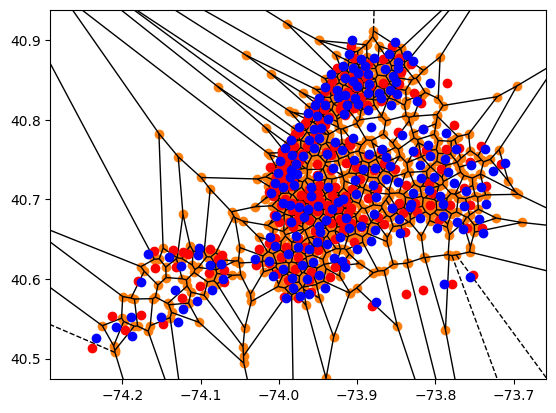

In [ ]:
fig = voronoi_plot_2d(vor)
plt.plot(estaciones_np[:, 0], estaciones_np[:, 1], 'ro')  # Estaciones en rojo
plt.plot(centroides[:, 0], centroides[:, 1], 'bo')        # Centroides de vecindarios en azul
plt.show()